### Data Preprocessing

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from datetime import datetime

# Load dataset
df = pd.read_csv("C:\\Users\\mathe\\Documents\\churn.csv")

# Sample the dataset
sample_size = 10000
sample_df = df.sample(n=sample_size, random_state=42)

# Convert date columns
sample_df['joining_date'] = pd.to_datetime(sample_df['joining_date'], dayfirst=True, errors='coerce', infer_datetime_format=True)
sample_df['last_visit_time'] = pd.to_datetime(sample_df['last_visit_time'], dayfirst=True, errors='coerce', infer_datetime_format=True)

# Handle categorical columns
categorical_cols = ['gender', 'region_category', 'membership_category',
                    'joined_through_referral', 'preferred_offer_types',
                    'medium_of_operation', 'internet_option',
                    'used_special_discount', 'offer_application_preference',
                    'past_complaint', 'complaint_status']

label_encoders = {}
for col in categorical_cols:
    if col in sample_df.columns:
        le = LabelEncoder()
        sample_df[col] = le.fit_transform(sample_df[col].astype(str))
        label_encoders[col] = le

# Feature Engineering: Days since joining and last visit
current_date = datetime.today()
sample_df['days_since_joining'] = (current_date - sample_df['joining_date']).dt.days
sample_df['days_since_last_visit'] = (current_date - sample_df['last_visit_time']).dt.days

# Drop original date columns
sample_df.drop(['sno','joining_date', 'last_visit_time'], axis=1, inplace=True, errors='ignore')

C:\Users\mathe\AppData\Local\Temp\ipykernel_22756\3658895441.py:32: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sample_df['joining_date'] = pd.to_datetime(sample_df['joining_date'], dayfirst=True, errors='coerce', infer_datetime_format=True)
C:\Users\mathe\AppData\Local\Temp\ipykernel_22756\3658895441.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sample_df['last_visit_time'] = pd.to_datetime(sample_df['last_visit_time'], dayfirst=True, errors='coerce', infer_datetime_format=True)
C:\Users\mathe\AppData\Local\Temp\ipykernel_22756\3658895441.py:33: 

### Feature Selection

In [45]:
# One-hot encoding
sample_df = pd.get_dummies(sample_df, drop_first=True)

# Remove constant features
sample_df = sample_df.loc[:, sample_df.nunique() > 1]

# Target Variable
X = sample_df.drop(['security_no', 'referral_id', 'churn_risk_score'], axis=1, errors='ignore')
y = sample_df['churn_risk_score']

# Feature Selection & Preprocessing
# Preprocessing pipelines
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('selector', SelectKBest(score_func=f_classif, k=min(10, len(numeric_cols))))  # Adjust k
])

categorical_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_selected = preprocessor.fit_transform(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

### SMOTE

In [46]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Before SMOTE:
 churn_risk_score
1    4338
0    3662
Name: count, dtype: int64
After SMOTE:
 churn_risk_score
0    4338
1    4338
Name: count, dtype: int64


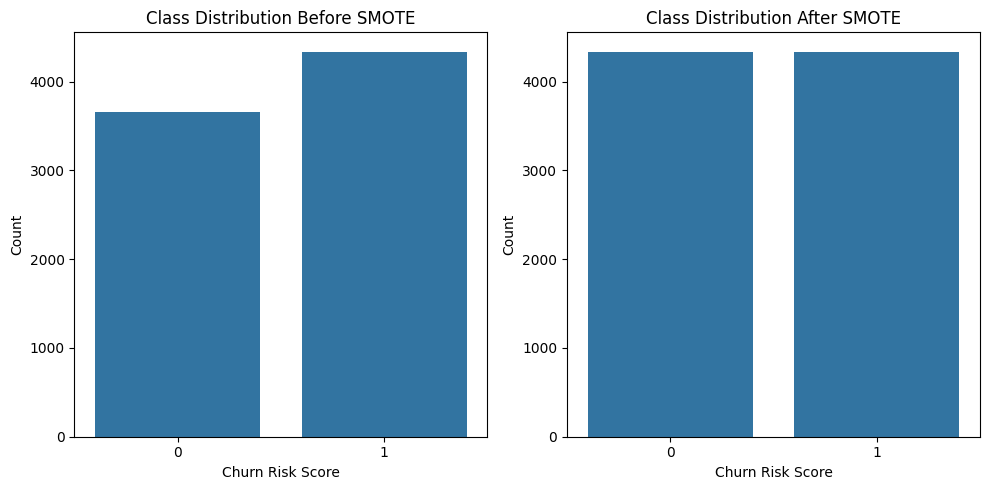

In [28]:
# Check new class balance
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_sm.value_counts())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Churn Risk Score')
plt.ylabel('Count')

# Check class balance after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_sm)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Churn Risk Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Testing Different Models

1. Logistic Regression

In [29]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train_sm, y_train_sm)

LogisticRegression(max_iter=10000)

In [30]:
y_pred_lr = model_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.7645
Confusion Matrix:
[[667 248]
 [223 862]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       915
           1       0.78      0.79      0.79      1085

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



2. Decision Tree

In [31]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

In [32]:
y_pred_dt = model_dt.predict(X_test)
print("=== Decision Tree ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

=== Decision Tree ===
Accuracy: 0.9190
Confusion Matrix:
[[ 833   82]
 [  80 1005]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       915
           1       0.92      0.93      0.93      1085

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



3. Random Forest Classifier

In [33]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [34]:
y_pred_rf = model_rf.predict(X_test)
print("=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
Accuracy: 0.9175
Confusion Matrix:
[[ 821   94]
 [  71 1014]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       915
           1       0.92      0.93      0.92      1085

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



4. XGB Classifier

In [35]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
y_pred_xgb = model_xgb.predict(X_test)
print("=== XGBoost ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

=== XGBoost ===
Accuracy: 0.9255
Confusion Matrix:
[[ 821   94]
 [  55 1030]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       915
           1       0.92      0.95      0.93      1085

    accuracy                           0.93      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.93      0.93      2000



5. LGBM Classifier

In [37]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train_sm, y_train_sm)

[LightGBM] [Info] Number of positive: 4338, number of negative: 4338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 8676, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [38]:
y_pred_lgbm = model_lgbm.predict(X_test)
print("=== LightGBM ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

=== LightGBM ===
Accuracy: 0.9305
Confusion Matrix:
[[ 839   76]
 [  63 1022]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       915
           1       0.93      0.94      0.94      1085

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Sentiment Analysis

In [39]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text), re.I | re.A)
    return text.lower()

def analyze_sentiment(text):
    text = clean_text(text)
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']

if 'feedback' in sample_df.columns:
    sample_df['sentiment_score'] = sample_df['feedback'].astype(str).apply(analyze_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Ensemble Learning

In [40]:
# Train Ensemble Model (Bagging with LightGBM)
ensemble_model = BaggingClassifier(estimator=LGBMClassifier(), n_estimators=50, random_state=42)
ensemble_model.fit(X_train_sm, y_train_sm)

# Model Evaluation
y_pred = ensemble_model.predict(X_test)


[LightGBM] [Info] Number of positive: 4338, number of negative: 4338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 8676, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515099 -> initscore=0.060415
[LightGBM] [Info] Start training from score 0.060415


[LightGBM] [Info] Number of positive: 4338, number of negative: 4338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 8676, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501614 -> initscore=0.006455
[LightGBM] [Info] Start training from score 0.006455
[LightGBM] [Info] Number of positive: 4338, number of negative: 4338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 8676, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497118 -> initscore=-0.011526
[LightGBM] [Info] Start training from score -0.011526
[LightGBM] [Info] Nu

C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LG

In [41]:
print("=== Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

=== Model Evaluation ===
Accuracy: 0.9270
Precision: 0.9270
Recall: 0.9270
F1 Score: 0.9269
Confusion Matrix:
[[ 833   82]
 [  64 1021]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       915
           1       0.93      0.94      0.93      1085

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



### Function to predict whether a customer is active or silent

In [42]:
def predict_customer_churn(customer_data):
    # Create a copy to avoid modifying the original
    customer_data = customer_data.copy()
    
    # Convert date columns to datetime format
    customer_data['joining_date'] = pd.to_datetime(customer_data['joining_date'], dayfirst=False, errors='coerce')
    customer_data['last_visit_time'] = pd.to_datetime(customer_data['last_visit_time'], dayfirst=False, errors='coerce')

    # Compute days_since_joining and days_since_last_visit
    current_date = datetime.today()
    customer_data['days_since_joining'] = (current_date - customer_data['joining_date']).days
    customer_data['days_since_last_visit'] = (current_date - customer_data['last_visit_time']).days

    # Remove original date columns
    customer_data.pop('joining_date', None)
    customer_data.pop('last_visit_time', None)

    # Compute sentiment score for feedback
    if 'feedback' in customer_data:
        customer_data['sentiment_score'] = analyze_sentiment(customer_data['feedback'])
        customer_data.pop('feedback', None)
    else:
        customer_data['sentiment_score'] = 0  # Default score if feedback is missing

    # Convert categorical features using label encoders
    categorical_cols_original = ['gender', 'region_category', 'membership_category',
                                 'joined_through_referral', 'preferred_offer_types',
                                 'medium_of_operation', 'internet_option',
                                 'used_special_discount', 'offer_application_preference',
                                 'past_complaint', 'complaint_status']
    
    for col in categorical_cols_original:
        if col in customer_data and col in label_encoders:
            try:
                customer_data[col] = label_encoders[col].transform([str(customer_data[col])])[0]
            except:
                customer_data[col] = 0  # Default value if encoding fails

    # Convert to DataFrame
    customer_df = pd.DataFrame([customer_data])
    
    # Drop columns that were dropped during training
    customer_df.drop(['security_no', 'referral_id'], axis=1, errors='ignore', inplace=True)
    
    # Apply one-hot encoding to match training data
    customer_df_encoded = pd.get_dummies(customer_df, drop_first=True)
    
    # Ensure all columns from training are present (add missing columns with 0)
    # Get the feature names from the training data
    training_features = X.columns.tolist()  # X from the training section
    for col in training_features:
        if col not in customer_df_encoded.columns:
            customer_df_encoded[col] = 0
    
    # Reorder columns to match training data
    customer_df_encoded = customer_df_encoded[training_features]
    
    # Apply the same feature selection & transformation
    customer_selected = preprocessor.transform(customer_df_encoded)

    # Make prediction
    prediction = ensemble_model.predict(customer_selected)
    churn_status = "Churn" if prediction[0] == 1 else "Active"
    
    return churn_status


In [43]:
# Example Customer Data with Date Input
new_customer = {
    'age': 29,
    'gender': 'M',
    'security_no': 'XYZ12345',  # Placeholder, likely ignored in prediction
    'region_category': 'City',
    'membership_category': 'Gold Membership',
    'joining_date': '2023-1-15',  # Needs conversion during preprocessing
    'joined_through_referral': 'Yes',
    'referral_id': 'CID54321',  # Placeholder, likely ignored in prediction
    'preferred_offer_types': 'Gift Vouchers/Coupons',
    'medium_of_operation': 'Smartphone',
    'internet_option': 'Wi-Fi',
    'last_visit_time': '2024-3-20',  # Needs conversion during preprocessing (FIXED: added quotes)
    'days_since_last_login': 5,
    'avg_time_spent': 250.50,
    'avg_transaction_value': 20000.75,
    'avg_frequency_login_days': '10',
    'points_in_wallet': 750.0,
    'used_special_discount': 'No',
    'offer_application_preference': 'Yes',
    'past_complaint': 'No',
    'complaint_status': 'Not Applicable',
    'feedback': 'Great customer service and fast delivery'
}

# Predict churn for new customer
churn_prediction = predict_customer_churn(new_customer)
print(f"Predicted Customer Status: {churn_prediction}")


C:\Users\mathe\AppData\Local\Temp\ipykernel_22756\3427161705.py:5: DeprecationWarning: 'count' is passed as positional argument
  text = re.sub(r'[^a-zA-Z\s]', '', str(text), re.I | re.A)
C:\Users\mathe\AppData\Local\Temp\ipykernel_22756\1672506123.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customer_df_encoded[col] = 0
C:\Users\mathe\AppData\Local\Temp\ipykernel_22756\1672506123.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customer_df_encoded[col] = 0
C:\Users\mathe\AppData\Local\Temp\ipykernel_22756\1672506123

Predicted Customer Status: Active


C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LG